In [1]:
# bibliotecas de manipulação e visualização
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split

# importando modelos
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans

In [2]:
import warnings
import os

os.environ['OMP_NUM_THREADS'] = '1'
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")

# Cluster das espécies da flor iris com Mistura Gaussiana

In [3]:
from sklearn.datasets import load_iris # importando o iris dataset

data_array = load_iris() # carregar os dados em array

df = pd.DataFrame(data_array.data, columns=data_array.feature_names) # converter o array para DataFrame

df['espécie'] = data_array.target # incluindo a variável alvo (rótulos)

df.rename(columns={'sepal length (cm)':'comprimento sépala (cm)', 'sepal width (cm)':'largura da sépala (cm)',
                   'petal length (cm)':'comprimento pétala (cm)', 'petal width (cm)':'largura da pétala (cm)'}, inplace=True)

### Visualização

In [4]:
display(df.head(), df.shape) # visualizando DataFrame, tamanho e dimensão

comprimento sépala (cm)  largura da sépala (cm)  comprimento pétala (cm)  \
0                      5.1                     3.5                      1.4   
1                      4.9                     3.0                      1.4   
2                      4.7                     3.2                      1.3   
3                      4.6                     3.1                      1.5   
4                      5.0                     3.6                      1.4   

   largura da pétala (cm)  espécie  
0                     0.2        0  
1                     0.2        0  
2                     0.2        0  
3                     0.2        0  
4                     0.2        0

(150, 5)

In [5]:
data_array.target_names # nomes das espécies

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

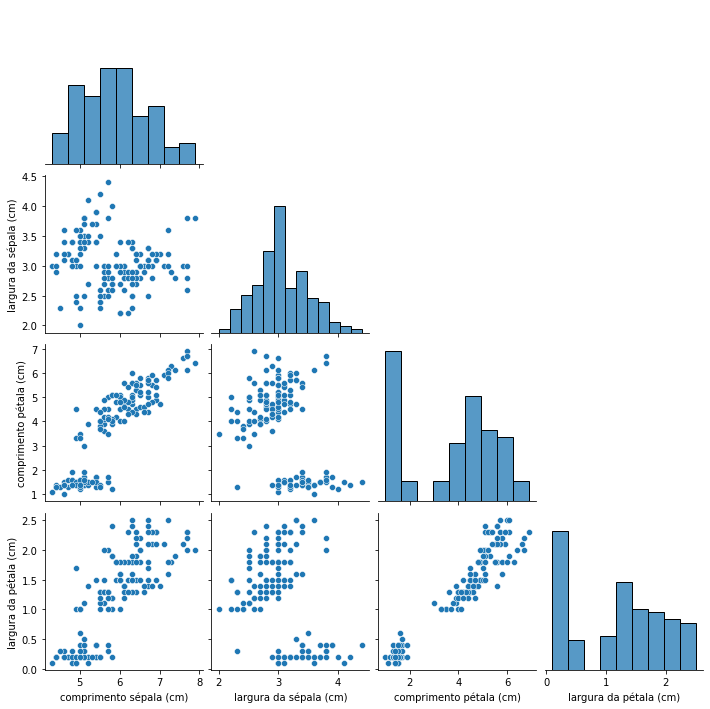

In [6]:
sns.pairplot(data=df.drop(columns='espécie', axis=1), corner=True);

### Divisão dos dados

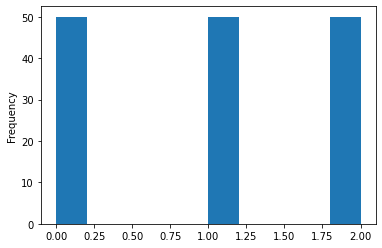

In [7]:
X = df.drop(columns='espécie', axis=1) # separando as features

y = df.espécie # separando a variável alvo

y.plot.hist();

In [8]:
# divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

### Seleção de número ótimo de clusters

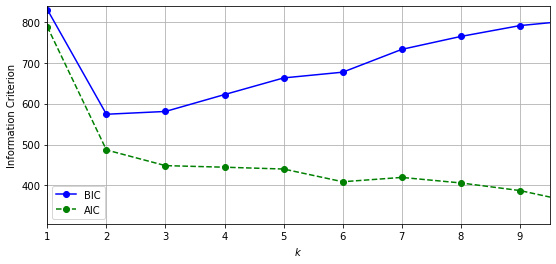

In [9]:
gmm_por_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)] # lista de modelos com 'k' cluster diferentes 
bics = [gmm.bic(X) for gmm in gmm_por_k] # lista da pontuação bic crescente em 'k'
aics = [gmm.aic(X) for gmm in gmm_por_k]# lista da pontuação aic crescente em 'k'

plt.figure(figsize=(9, 4))

plt.plot(range(1, 11), bics, "bo-", label="BIC") # plot bic
plt.plot(range(1, 11), aics, "go--", label="AIC") # plot aic

plt.xlabel("$k$")
plt.ylabel("Information Criterion")
plt.axis([1, 9.5, min(aics) - 50, max(aics) + 50]) # formata o eixo x
plt.legend()
plt.grid()

plt.show()

In [10]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42).fit(X) # treino de bgm

In [11]:
bgm.weights_.round(2) # probabilidade de ser k cluster

array([0.01, 0.56, 0.33, 0.11, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

#### Pelo cotovelo, se obtem primeiramente um k = 2 para ambas métricas. Porém, para BIC k = 3, que é o número real, possui praticamente a mesma pontuação. Se observarmos nos pontos de dispersão, os dados aparentam possuírem dois clusters. Dessa forma não foi surpresa a pontuação escolher k = 2.

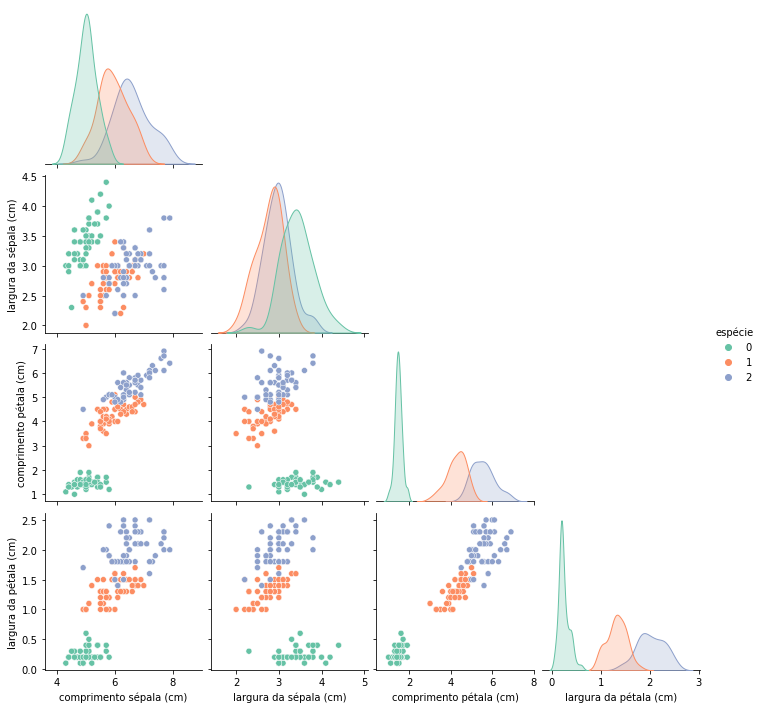

In [12]:
sns.pairplot(data=df, hue='espécie', corner=True, palette='Set2');

### Treinamento e predição

In [13]:
k = 3 # número de clusters
gmm = GaussianMixture(n_components=k, n_init=10, random_state=42) # modelo de mistura gaussiana com os hiperparâmetros

y_pred_val = gmm.fit_predict(X_train) # treino e atribuição das instâncias aos clusters

mapping = {}
for class_id in np.unique(y_train):  # itera sobre cada classe única em 'y' array([0, 1, 2])
    mode, _ = stats.mode(y_pred_val[y_train==class_id])  # calcula o valor modal das previsões 'y_pred' para a classe atual
    mapping[mode[0]] = class_id  # associa o valor modal à classe atual no dicionário 'mapping'
    
    print(mode[0]) # print para comparação

print(mapping) # print para comparação

1
2
0
{1: 0, 2: 1, 0: 2}


In [14]:
# substitui as previsões 'y_pred' pelos valores mapeados em 'mapping'
y_pred_val = np.array([mapping[cluster_id] for cluster_id in y_pred_val])

### Validação

In [15]:
print(f'\
Acurácia: {((y_pred_val==y_train).sum() / len(y_pred_val)):.2%}\n\
Erros: {len(y_pred_val) - (y_pred_val==y_train).sum()}')

Acurácia: 97.50%
Erros: 3


### Teste

In [16]:
y_pred_test = gmm.predict(X_test)

mapping = {}
for class_id in np.unique(y_test):  # itera sobre cada classe única em 'y' array([0, 1, 2])
    mode, _ = stats.mode(y_pred_test[y_test==class_id])  # calcula o valor modal das previsões 'y_pred' para a classe atual
    mapping[mode[0]] = class_id  # associa o valor modal à classe atual no dicionário 'mapping'
    
# substitui as previsões 'y_pred' pelos valores mapeados em 'mapping'
y_pred_test = np.array([mapping[cluster_id] for cluster_id in y_pred_test])

In [17]:
print(f'\
Acurácia: {((y_pred_test==y_test).sum() / len(y_pred_test)):.2%}\n\
Erros: {len(y_pred_test) - (y_pred_test==y_test).sum()}')

Acurácia: 96.67%
Erros: 1


O autor não divide em treino e teste os dados e obtém uma acurácia geral de 96%.

-------------------------------------------------
# Clustering com K-Means para Segmentação de Imagens

- A segmentação de imagens é um processo de análise de imagens que consiste em dividir uma imagem em partes ou regiões distintas.
- Isso é feito para simplificar a representação da imagem e/ou extrair informações relevantes para uma determinada aplicação. O processo envolve a identificação de objetos, texturas, cores, formas e outras características da imagem, para separar as diferentes regiões.

### Download da imagem

In [18]:
# downloads da imagem da joaninha
import urllib.request # permite abrir URL's
from pathlib import Path # usada para manipular caminhos de arquivos e diretórios

IMAGES_PATH = Path() / "images" / "unsupervised_learning"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
filename = "ladybug.png"
filepath = IMAGES_PATH / filename
if not filepath.is_file():
    print("Downloading", filename)
    url = f"{homl3_root}/images/unsupervised_learning/{filename}"
    urllib.request.urlretrieve(url, filepath)

### Visualização

In [19]:
import PIL # biblioteca de processamento de imagens

image = np.asarray(PIL.Image.open(filepath)) # transformando a imagem em array numpy
image.shape # altura, largura e canais de cor (RGB)

(533, 800, 3)

In [20]:
print(image) # print do array 3D

[[[ 25  29   2]
  [ 24  28   1]
  [ 24  29   0]
  ...
  [ 57 105  21]
  [ 56 103  22]
  [ 52  99  19]]

 [[ 24  28   1]
  [ 23  27   0]
  [ 23  27   0]
  ...
  [ 60 108  22]
  [ 59 106  25]
  [ 55 102  22]]

 [[ 23  27   2]
  [ 22  26   1]
  [ 22  26   0]
  ...
  [ 66 114  28]
  [ 63 111  27]
  [ 58 105  24]]

 ...

 [[ 14  18   1]
  [ 14  18   1]
  [ 13  20   2]
  ...
  [ 13  61   3]
  [  9  56   2]
  [  5  51   2]]

 [[ 14  18   1]
  [ 14  18   1]
  [ 12  19   1]
  ...
  [ 11  59   1]
  [  7  54   0]
  [  3  49   0]]

 [[ 13  17   0]
  [ 13  17   0]
  [ 11  18   0]
  ...
  [ 10  58   0]
  [  5  52   0]
  [  2  48   0]]]


In [21]:
image[0].shape # dimensão 2D da largura e canais de cores

(800, 3)

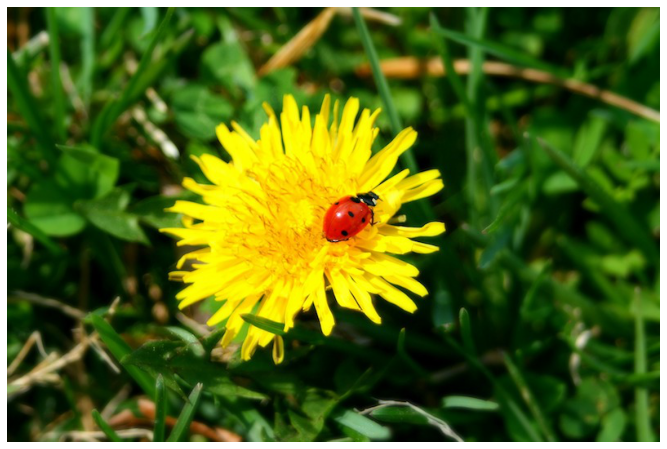

In [22]:
fig, ax = plt.subplots(figsize=(18, 8))

ax.imshow(image) # exibe dados como uma imagem rasterizada 2D
ax.axis('off')

plt.show()

O array está ordenado no sentido horizontal da largura, de instância em instância. Cada instância possui 800 listas de pixels com 3 features cada, canal RGB, de sinal de 0 a 255. O sinal mede o brilho, onde quanto maior, mais clara a cor e quanto menor, mais escuro.

-----------------------------
### Preparação dos dados e treino

In [23]:
# reshape do array
X = image.reshape(-1, 3) # -1 transforma o array para unidimensional de modo que a forma resultante
                         # é compatível com a forma original e não há informações perdidas
                         # O 3 conserva os canais RGB de cada pixel e final, resulta em uma matriz 2D
        
X.shape

(426400, 3)

In [24]:
kmeans = KMeans(n_clusters=6, random_state=42) # kmeans para agrupar as cores em 6 cores médias
kmeans.fit(X)

KMeans(n_clusters=6, random_state=42)

In [25]:
display(kmeans.cluster_centers_, # contém as coordenadas dos centróides, cores médias RGB
        kmeans.labels_, # contém os rótulos para cada pixel da imagem
        len(kmeans.labels_)) # tamanho do array

array([[ 38.36377317,  79.60199796,   7.83458595],
       [192.24714991, 135.17772673,  16.68861664],
       [ 81.36887917, 123.39833736,  31.38089997],
       [147.8179787 , 158.43600935,  95.74642764],
       [  8.18206974,  33.7611387 ,   1.73055663],
       [248.17163601, 229.70555065,   6.50054948]])

array([4, 4, 4, ..., 4, 4, 4])

426400

In [26]:
segmented_img = kmeans.cluster_centers_[kmeans.labels_] # indexação, acessando os valores médios das cores dos
                                                        # clusters através do rótulo, que nesse caso serve como index
                                                        # por estar cluster_centers_ ser ordenado

segmented_img = segmented_img.reshape(image.shape) # redimensiona a matriz da imagem

display(segmented_img[:1], segmented_img.shape) # array tridimensional redimensionado no formato original

array([[[  8.18206974,  33.7611387 ,   1.73055663],
        [  8.18206974,  33.7611387 ,   1.73055663],
        [  8.18206974,  33.7611387 ,   1.73055663],
        ...,
        [ 81.36887917, 123.39833736,  31.38089997],
        [ 38.36377317,  79.60199796,   7.83458595],
        [ 38.36377317,  79.60199796,   7.83458595]]])

(533, 800, 3)

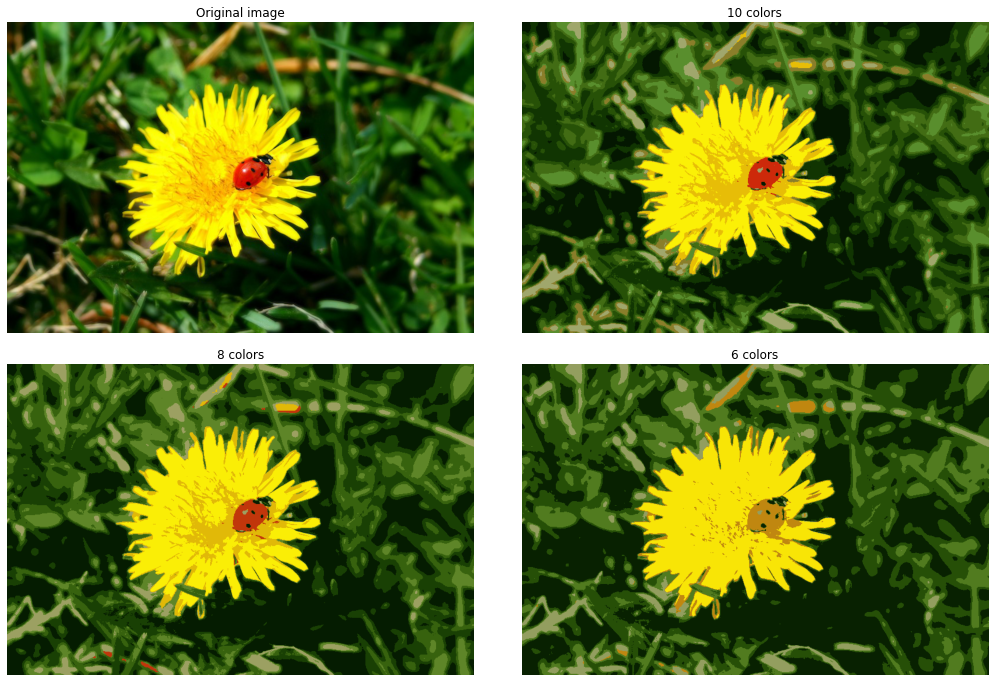

In [27]:
# Cria uma lista vazia para armazenar as imagens segmentadas
segmented_imgs = []

# Define uma tupla com a quantidade de cores que cada imagem segmentada terá
n_colors = (10, 8, 6)

# Itera sobre cada quantidade de cores da tupla
for n_clusters in n_colors: # treina K-Means de acordo com o cluster da iteração
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X) 
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

plt.figure(figsize=(18, 12))
plt.subplots_adjust(wspace=0.05, hspace=0.1) # wspace largura / hspace altura entre os subplots

# Cria a primeira subplot, mostrando a imagem original
plt.subplot(2, 2, 1)
plt.imshow(image) # exibe dados como uma imagem rasterizada 2D
plt.title("Original image")
plt.axis('off') # desativa os eixos

# Itera sobre cada quantidade de cores da tupla novamente
for idx, n_clusters in enumerate(n_colors):
    # Cria uma subplot para mostrar a imagem segmentada com a quantidade de cores da iteração atual
    plt.subplot(2, 2, 2 + idx)
    # Mostra a imagem segmentada, normalizando os valores de pixel entre 0 e 1
    plt.imshow(segmented_imgs[idx] / 255)
    # Define o título da subplot com a quantidade de cores da iteração atual
    plt.title(f"{n_clusters} colors")
    plt.axis('off')

# Mostra a figura na tela
plt.show()

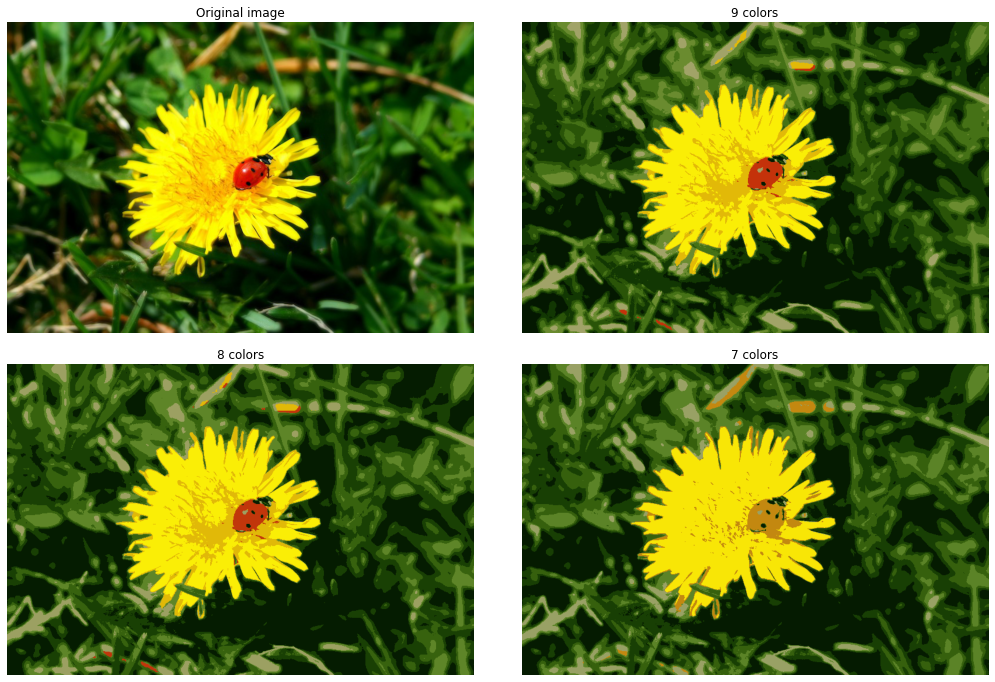

In [28]:
segmented_imgs = []
modelos = []

n_colors = (9, 8, 7)

for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    modelos.append(kmeans)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

plt.figure(figsize=(18, 12))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(2, 2, 2 + idx)
    plt.imshow(segmented_imgs[idx] / 255)
    plt.title(f"{n_clusters} colors")
    plt.axis('off')

plt.show()

- Oito e nove clusters obtiveram ótimos desempenhos na segmentação.
- O número de clusters (cores) oito vai ser escolhido por separar bem e ser computacionalmente mais barato.

# Clustering para aprendizado semi-supervisionado

- Um caso de uso para clustering é o aprendizado semi-supervisionado, quando temos muitas instâncias não rotuladas e muito poucas instâncias rotuladas.

- Pode-se utiliza o _digits dataset_, que é um conjunto de dados simples do tipo MNIST contendo 1.797 imagens 8 × 8 em escala de cinza representando os dígitos de 0 a 9.

In [29]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True) # divisão em features e target
X_train, y_train = X_digits[:1400], y_digits[:1400] # treino
X_test, y_test = X_digits[1400:], y_digits[1400:] # teste

In [30]:
X_digits, X_digits.shape # valores vão de 0 a 16 em escala de cinza

(array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 (1797, 64))

Cada instância representa uma imagem de digito em 1D, porém na verdade ela é uma matriz 2D 8x8.

#### Desempenho de um modelo de regressão logística quando temos apenas 50 instâncias rotuladas.

In [31]:
from sklearn.linear_model import LogisticRegression

In [32]:
n_labeled = 50

log_reg = LogisticRegression(max_iter=10_000, random_state=42) # nº máximo de iteração para otimizção do algoritmo
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled]) # treinando com apenas 50 instâncias

log_reg.score(X_test, y_test) # acurácia geral

0.7481108312342569

Desempenho de um modelo de regressão logística com toda base de dados

In [33]:
log_reg_full = LogisticRegression(max_iter=10_000) # nº máximo de iteração para otimizção do algoritmo
log_reg_full.fit(X_train, y_train)

log_reg_full.score(X_test, y_test) # acurácia geral

0.906801007556675

- Obviamente, os dados completos retorna uma acurácia muito melhor.

- Primeiro, vamos agrupar o conjunto de treinamento em 50 clusters e, em seguida, para cada cluster, encontrar a imagem mais próxima do centróide. Chamaremos essas imagens de imagens **representativas**

In [34]:
k = 50

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_train)

X_digits_dist = kmeans.transform(X_train) # retorna a distância das intâncias com cada centróide
display(X_digits_dist, X_digits_dist.shape)

array([[53.8347602 , 41.42507119, 40.38645515, ..., 46.70298587,
        43.32913642, 41.73144964],
       [22.96665235, 50.3636375 , 45.70161035, ..., 48.27458499,
        43.06000537, 50.03512655],
       [29.42934195, 50.1412468 , 43.36356873, ..., 50.49457617,
        47.66591091, 53.60050269],
       ...,
       [49.57764931, 56.45575913, 36.34319282, ..., 46.91590586,
        54.17253975, 56.99134925],
       [49.46706914, 55.89670767, 33.61503416, ..., 46.99966903,
        53.61297942, 54.25569607],
       [38.3721188 , 43.90294928, 48.93405716, ..., 43.3609143 ,
        41.15263129, 37.04745455]])

(1400, 50)

In [35]:
# retorna índices das distâncias mínimas de cada coluna, ou seja, para cada cluster (são 50),
# retorne a instância mais representativa
representative_digit_idx = X_digits_dist.argmin(axis=0) # índices
X_representative_digits = X_train[representative_digit_idx] # instâncias que representam cada cluster

In [36]:
display(X_representative_digits, X_representative_digits.shape) # instâncias representativas para cada cluster

array([[ 0.,  0.,  1., ...,  9.,  0.,  0.],
       [ 0.,  0.,  4., ...,  9.,  1.,  0.],
       [ 0.,  0.,  0., ..., 16.,  7.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  6.,  0.,  0.],
       [ 0.,  0., 12., ...,  9.,  0.,  0.],
       [ 0.,  0.,  2., ...,  0.,  0.,  0.]])

(50, 64)

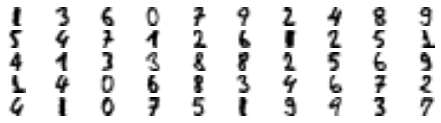

In [37]:
plt.figure(figsize=(8, 2))
for index, imagem_digito in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(imagem_digito.reshape(8, 8), cmap="binary", # especifica que a imagem deve ser exibida em preto e branco
               interpolation="bilinear") # método de interpolação bilinear
    plt.axis('off')

save_fig("representative_images_plot", tight_layout=False)
plt.show()

In [38]:
# valores de y representativos
y_representative_digits = np.array([
    1, 3, 6, 0, 7, 9, 2, 4, 8, 9,
    5, 4, 7, 1, 2, 6, 1, 2, 5, 1,
    4, 1, 3, 3, 8, 8, 2, 5, 6, 9,
    1, 4, 0, 6, 8, 3, 4, 6, 7, 2,
    4, 1, 0, 7, 5, 1, 9, 9, 3, 7
])

Agora há um conjunto de dados com apenas 50 instâncias rotuladas, mas em vez de serem instâncias completamente aleatórias, cada uma delas é uma imagem representativa do seu cluster.
- Será verificado se o desempenho é melhor.

In [39]:
log_reg = LogisticRegression(max_iter=10_000, random_state=42)

log_reg.fit(X_representative_digits, y_representative_digits) # treinando as features representativa e seus
                                                              # respectivos rótulos
log_reg.score(X_test, y_test) # acurácia

0.8488664987405542

- Embora o modelo esteja sendo treinado em apenas 50 instâncias, a precisão aumentou de 74,8% para 84,9%. 
- Como rotular instâncias pode ser caro e difícil, especialmente quando deve ser feito manualmente por especialistas, é uma boa ideia fazê-los rotular instâncias representativas em vez de apenas aleatórias.

- Atingiu-se um desempenho muito bom, mas se propagarmos os rótulos para todas as outras instâncias no mesmo cluster, o algoritmo pode ter um desempenho melhor.

In [40]:
kmeans.labels_

array([32, 41, 39, ..., 40, 40, 43])

In [41]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64) # cria um array vazio do tamanho de X_train e int64

for k in range(k): # k = 50 iterações
    y_train_propagated[kmeans.labels_ == k] = y_representative_digits[k]
    # para todas instâncias que foram atribuídas ao cluster 'k' o índice é True, com esse índice, atribua o rótulo
    # específico para k. No caso, em y_representative_digits os cluster estão ordenados, por isso é possível fazer
    # dessa forma.

In [42]:
y_train_propagated.shape # os rótulos foram propagados para todas as features

(1400,)

In [43]:
log_reg = LogisticRegression(max_iter=10_000, random_state=42)

log_reg.fit(X_train, y_train_propagated) # treino com os dados propagados

log_reg.score(X_test, y_test) # acurácia

0.8942065491183879

O algoritmo de Regressão Logística com os dados propagados obtiveram um desempenho ótimo de 89,42% de acurácia geral, sendo muito próximo ao do mesmo algoritmo treinado com a base de dados completa com os rótulos verdadeiros importados "y_train", que foi de 90,68%.

# Feature Engineering com aprendizado não supervisionado

In [44]:
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()
housing.rename(columns={'housing_median_age':'idade_media', 'total_rooms':'comodos_total',
                        'total_bedrooms':'quartos_total', 'population':'populacao', 'households':'casas',
                        'median_income':'renda_media', 'median_house_value':'preco_medio_casa',
                        'ocean_proximity':'proximidade_oceano'}, inplace=True)

display(housing.head(), housing.shape)

longitude  latitude  idade_media  comodos_total  quartos_total  populacao  \
0    -122.23     37.88         41.0          880.0          129.0      322.0   
1    -122.22     37.86         21.0         7099.0         1106.0     2401.0   
2    -122.24     37.85         52.0         1467.0          190.0      496.0   
3    -122.25     37.85         52.0         1274.0          235.0      558.0   
4    -122.25     37.85         52.0         1627.0          280.0      565.0   

    casas  renda_media  preco_medio_casa proximidade_oceano  
0   126.0       8.3252          452600.0           NEAR BAY  
1  1138.0       8.3014          358500.0           NEAR BAY  
2   177.0       7.2574          352100.0           NEAR BAY  
3   219.0       5.6431          341300.0           NEAR BAY  
4   259.0       3.8462          342200.0           NEAR BAY

(20640, 10)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(housing.drop(columns='preco_medio_casa', axis=1),
                                                    housing.preco_medio_casa, test_size=0.2, random_state=42) 

In [46]:
housing_train = X_train.copy()

housing_train['preco_medio_casa'] = y_train.copy()

housing_train.reset_index(drop=True, inplace=True)

display(housing_train.head(), housing_train.shape)

longitude  latitude  idade_media  comodos_total  quartos_total  populacao  \
0    -117.22     32.75         34.0         6001.0         1111.0     2654.0   
1    -117.03     32.69         10.0          901.0          163.0      698.0   
2    -122.27     37.74         28.0         6909.0         1554.0     2974.0   
3    -121.82     37.25         25.0         4021.0          634.0     2178.0   
4    -115.98     33.32          8.0          240.0           46.0       63.0   

    casas  renda_media proximidade_oceano  preco_medio_casa  
0  1072.0       4.5878         NEAR OCEAN          291000.0  
1   167.0       4.6648         NEAR OCEAN          156100.0  
2  1484.0       3.6875           NEAR BAY          353900.0  
3   650.0       5.1663          <1H OCEAN          241200.0  
4    24.0       1.4688             INLAND           53800.0

(16512, 10)

In [47]:
housing_train.proximidade_oceano.unique()

array(['NEAR OCEAN', 'NEAR BAY', '<1H OCEAN', 'INLAND', 'ISLAND'],
      dtype=object)

### Pequena exploração de dados

In [48]:
corr_matrix = housing_train.corr() # matriz de correlação linear

corr_matrix = corr_matrix['preco_medio_casa'].sort_values(ascending=False)[1:] # correlações só para preço das casas
corr_matrix

renda_media      0.687013
comodos_total    0.134060
idade_media      0.104714
casas            0.065798
quartos_total    0.049993
populacao       -0.025820
longitude       -0.043603
latitude        -0.146324
Name: preco_medio_casa, dtype: float64

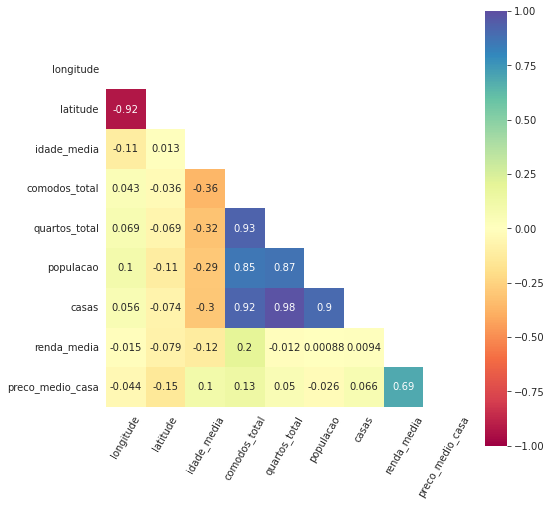

In [49]:
corr = housing_train.corr()
# máscara
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 8))
    #heatmap com os máximo e mínimos de acordo com o coeficiente de correlação de Pearson
    ax = sns.heatmap(corr, mask=mask, vmax=1, vmin=-1, square=True, annot = True, cmap='Spectral')
    plt.xticks(rotation = 60)
plt.show()

- As features não possuem muita correlação linear com a variável alvo.
- Algumas features podem obter ser melhores aproveitadas ao correlacionalas.
  - Número de comodos médio por casas
  - Número de moradores médios por casas
  - Proporção média de quartos por numero de comodos

In [50]:
housing_train["med_comodos_p_casa"] = housing_train["comodos_total"] / housing_train["casas"]
housing_train["prop_quartos_p_comodos"] = housing_train["quartos_total"] / housing_train["comodos_total"]
housing_train["med_moradores_p_casa"] = housing_train["populacao"] / housing_train["casas"]

In [51]:
corr_matrix = housing_train.corr() # matriz de correlação linear

corr_matrix = corr_matrix['preco_medio_casa'].sort_values(ascending=False)[1:] # correlações só para preço das casas
corr_matrix

renda_media               0.687013
med_comodos_p_casa        0.146940
comodos_total             0.134060
idade_media               0.104714
casas                     0.065798
quartos_total             0.049993
med_moradores_p_casa     -0.021577
populacao                -0.025820
longitude                -0.043603
latitude                 -0.146324
prop_quartos_p_comodos   -0.254817
Name: preco_medio_casa, dtype: float64

As novas features se correlacionaram ligereiramente quanto ao preço médio das casas.

A localização da casa (latitude e longitude) não se correlaciona linearmente com os dados e pode-se fazer um estudo mais profundo dessa localização.

### Visualizando a latitude e longitude

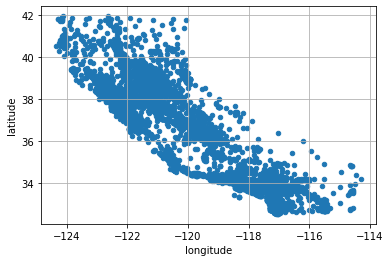

In [52]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)

plt.show()

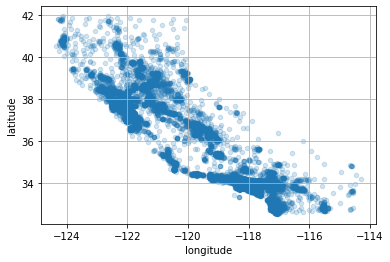

In [53]:
# mudando alpha (transparência), pode-se observar a densidade dos dados
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)

plt.show()

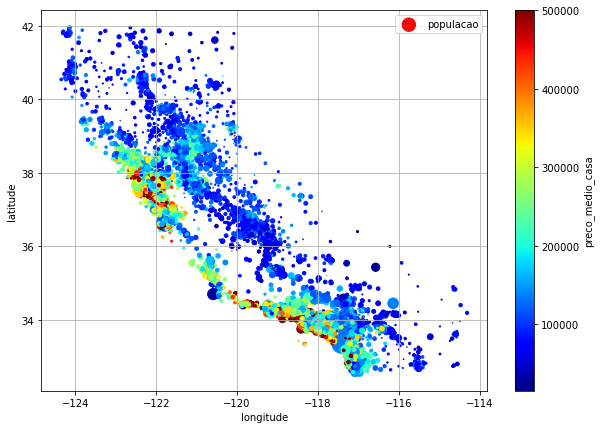

In [54]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["populacao"] / 100, label="populacao", # s atribui o tamanho de cada istância de acordo com a população
             c="preco_medio_casa", cmap="jet", colorbar=True, # c atribui a mudança de cores aos preços das casas
             legend=True, sharex=False, figsize=(10, 7))

plt.show()

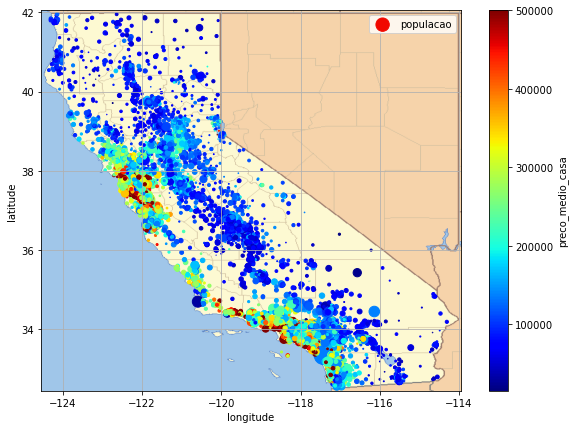

In [55]:
# Download the California image
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["populacao"] / 100, label="populacao", # s atribui o tamanho de cada istância de acordo com a população
             c="preco_medio_casa", cmap="jet", colorbar=True, # c atribui a mudança de cores aos preços das casas
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

plt.show()

Como pode-se observar,a latitude e longitude possui correlação com os preços médios da casas.

### Criando a nova feature de similaridade

In [56]:
X_similaridade = housing_train[["latitude", "longitude"]]

In [57]:
kmeans = KMeans(n_clusters=10, random_state=42) # k-means é utilizado para encontrar as posições dos centróides
kmeans.fit(X_similaridade, sample_weight=y_train) # sample_weight atribuiu pesos as instâncias de acordo com o preços das casas y

KMeans(n_clusters=10, random_state=42)

Cada instância possui 10 features, pois é uma similaridade para cada cluster

-----------

**Por que não apenas encontrar a similaridade com as distâncias das instâncias e cluster no agrupamento suave (transform) de k-means?**

O agrupamento suave do k-means é mais adequado para dados em que as instâncias podem ser claramente separadas em grupos distintos, enquanto o uso do kernel RBF é mais adequado para dados em que as instâncias podem estar mais próximas umas das outras e podem ter sobreposição entre os grupos.

In [58]:
from sklearn.metrics.pairwise import rbf_kernel # RBF = Função de Base Radial / RBF é uma técnica de análise de similaridade
                                                # que usa uma função de kernel para medir a similaridade entre as instâncias.

similaridades = rbf_kernel(X_similaridade, kmeans.cluster_centers_, gamma=1) # gamma parâmetro de escala que controla a suavidade da função

In [59]:
display(similaridades, similaridades.shape)

array([[1.38537442e-23, 5.35811497e-02, 1.12670263e-09, ...,
        2.51879509e-19, 5.73333323e-24, 4.96733576e-18],
       [1.02641795e-24, 2.89111503e-02, 2.78309674e-10, ...,
        2.32562455e-20, 5.75138953e-25, 6.15631911e-19],
       [9.73211642e-01, 2.23065133e-13, 1.99501721e-04, ...,
        7.22750158e-01, 9.68392056e-02, 2.08090549e-01],
       ...,
       [8.66501953e-06, 2.57855032e-03, 8.33195623e-01, ...,
        3.77601619e-04, 3.32145834e-05, 5.88834132e-03],
       [1.49823781e-18, 2.74103653e-01, 5.11920455e-06, ...,
        5.26226649e-15, 8.89222309e-18, 4.49475573e-13],
       [7.78818538e-12, 7.32508491e-01, 1.78028146e-03, ...,
        6.42250918e-09, 1.51225987e-12, 2.73673266e-08]])

(16512, 10)

In [60]:
housing_train["max_similaridade"] = similaridades.max(axis=1) # para cada instância retorna a maior similaridade com os clusters

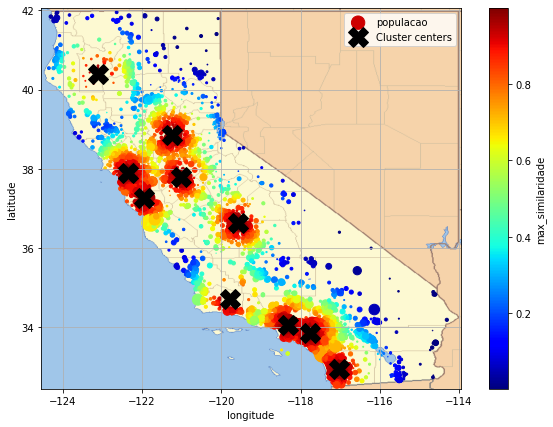

In [61]:
housing_train.plot(kind="scatter", x="longitude", y="latitude", grid=True,
                     s=housing_train["populacao"] / 100, label="populacao",
                     c="max_similaridade",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(kmeans.cluster_centers_[:, 1], # posição X do centro de cluster
         kmeans.cluster_centers_[:, 0], # posição y do centro de cluster
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

plt.show()

In [62]:
corr_matrix = housing_train.corr() # matriz de correlação linear

corr_matrix = corr_matrix['preco_medio_casa'].sort_values(ascending=False)[1:] # correlações só para preço das casas
corr_matrix

renda_media               0.687013
max_similaridade          0.341653
med_comodos_p_casa        0.146940
comodos_total             0.134060
idade_media               0.104714
casas                     0.065798
quartos_total             0.049993
med_moradores_p_casa     -0.021577
populacao                -0.025820
longitude                -0.043603
latitude                 -0.146324
prop_quartos_p_comodos   -0.254817
Name: preco_medio_casa, dtype: float64

De maneira geral, obteve-se um aumento significativo na linearidade entre as features e a variável alvo (preço das casas).

## Detecção de anomalias no dataset de cancer

In [99]:
from sklearn.datasets import load_breast_cancer

# carrega o conjunto de dados do câncer de mama
data = load_breast_cancer()

# variável alvo
y = data.target

# convertendo para DataFrame
X = pd.DataFrame(data.data, columns=data.feature_names)

columns_pt = {'mean radius': 'raio médio',
              'mean texture': 'textura média',
              'mean perimeter': 'perímetro médio',
              'mean area': 'área média',
              'mean smoothness': 'suavidade média',
              'mean compactness': 'compacidade média',
              'mean concavity': 'concavidade média',
              'mean concave points': 'pontos côncavos médios',
              'mean symmetry': 'simetria média',
              'mean fractal dimension': 'dimensão fractal média',
              'radius error': 'erro do raio',
              'texture error': 'erro de textura',
              'perimeter error': 'erro de perímetro',
              'area error': 'erro de área',
              'smoothness error': 'erro de suavidade',
              'compactness error': 'erro de compacidade',
              'concavity error': 'erro de concavidade',
              'concave points error': 'erro de pontos côncavos',
              'symmetry error': 'erro de simetria',
              'fractal dimension error': 'erro de dimensão fractal',
              'worst radius': 'raio pior',
              'worst texture': 'textura pior',
              'worst perimeter': 'perímetro pior',
              'worst area': 'área pior',
              'worst smoothness': 'suavidade pior',
              'worst compactness': 'compacidade pior',
              'worst concavity': 'concavidade pior',
              'worst concave points': 'pontos côncavos piores',
              'worst symmetry': 'simetria pior',
              'worst fractal dimension': 'dimensão fractal pior'}

# renomeia as colunas usando o dicionário de mapeamento
X.rename(columns=columns_pt, inplace=True)

display(X.head(), X.shape)

raio médio  textura média  perímetro médio  área média  suavidade média  \
0       17.99          10.38           122.80      1001.0          0.11840   
1       20.57          17.77           132.90      1326.0          0.08474   
2       19.69          21.25           130.00      1203.0          0.10960   
3       11.42          20.38            77.58       386.1          0.14250   
4       20.29          14.34           135.10      1297.0          0.10030   

   compacidade média  concavidade média  pontos côncavos médios  \
0            0.27760             0.3001                 0.14710   
1            0.07864             0.0869                 0.07017   
2            0.15990             0.1974                 0.12790   
3            0.28390             0.2414                 0.10520   
4            0.13280             0.1980                 0.10430   

   simetria média  dimensão fractal média  ...  raio pior  textura pior  \
0          0.2419                 0.07871  ...      25.38         17.33   
1          0.1812                 0.05667  ...      24.99         23.41   
2          0.2069                 0.05999  ...      23.57         25.53   
3          0.2597                 0.09744  ...      14.91         26.50   
4          0.1809                 0.05883  ...      22.54         16.67   

   perímetro pior  área pior  suavidade pior  compacidade pior  \
0          184.60     2019.0          0.1622            0.6656   
1          158.80     1956.0          0.1238            0.1866   
2          152.50     1709.0          0.1444            0.4245   
3           98.87      567.7          0.2098            0.8663   
4          152.20     1575.0          0.1374            0.2050   

   concavidade pior  pontos côncavos piores  simetria pior  \
0            0.7119                  0.2654         0.4601   
1            0.2416                  0.1860         0.2750   
2            0.4504                  0.2430         0.3613   
3            0.6869                  0.2575         0.6638   
4            0.4000                  0.1625         0.2364   

   dimensão fractal pior  
0                0.11890  
1                0.08902  
2                0.08758  
3                0.17300  
4                0.07678  

[5 rows x 30 columns]

(569, 30)

In [100]:
data.target_names # 0 é tumor maligno e 1 é tumor maligno

array(['malignant', 'benign'], dtype='<U9')

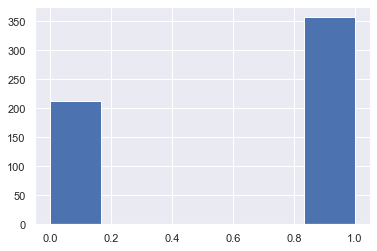

Número de tumores malignos: 212


In [101]:
plt.hist(y, bins=6)

plt.show()
 
print(f'Número de tumores malignos: {len(y[y==0])}')

Como pode-se ver, existem mais labels para tumores benignos do que para malignos.

In [102]:
X.info() # todos dados são float e não há vazios

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   raio médio                569 non-null    float64
 1   textura média             569 non-null    float64
 2   perímetro médio           569 non-null    float64
 3   área média                569 non-null    float64
 4   suavidade média           569 non-null    float64
 5   compacidade média         569 non-null    float64
 6   concavidade média         569 non-null    float64
 7   pontos côncavos médios    569 non-null    float64
 8   simetria média            569 non-null    float64
 9   dimensão fractal média    569 non-null    float64
 10  erro do raio              569 non-null    float64
 11  erro de textura           569 non-null    float64
 12  erro de perímetro         569 non-null    float64
 13  erro de área              569 non-null    float64
 14  erro de su

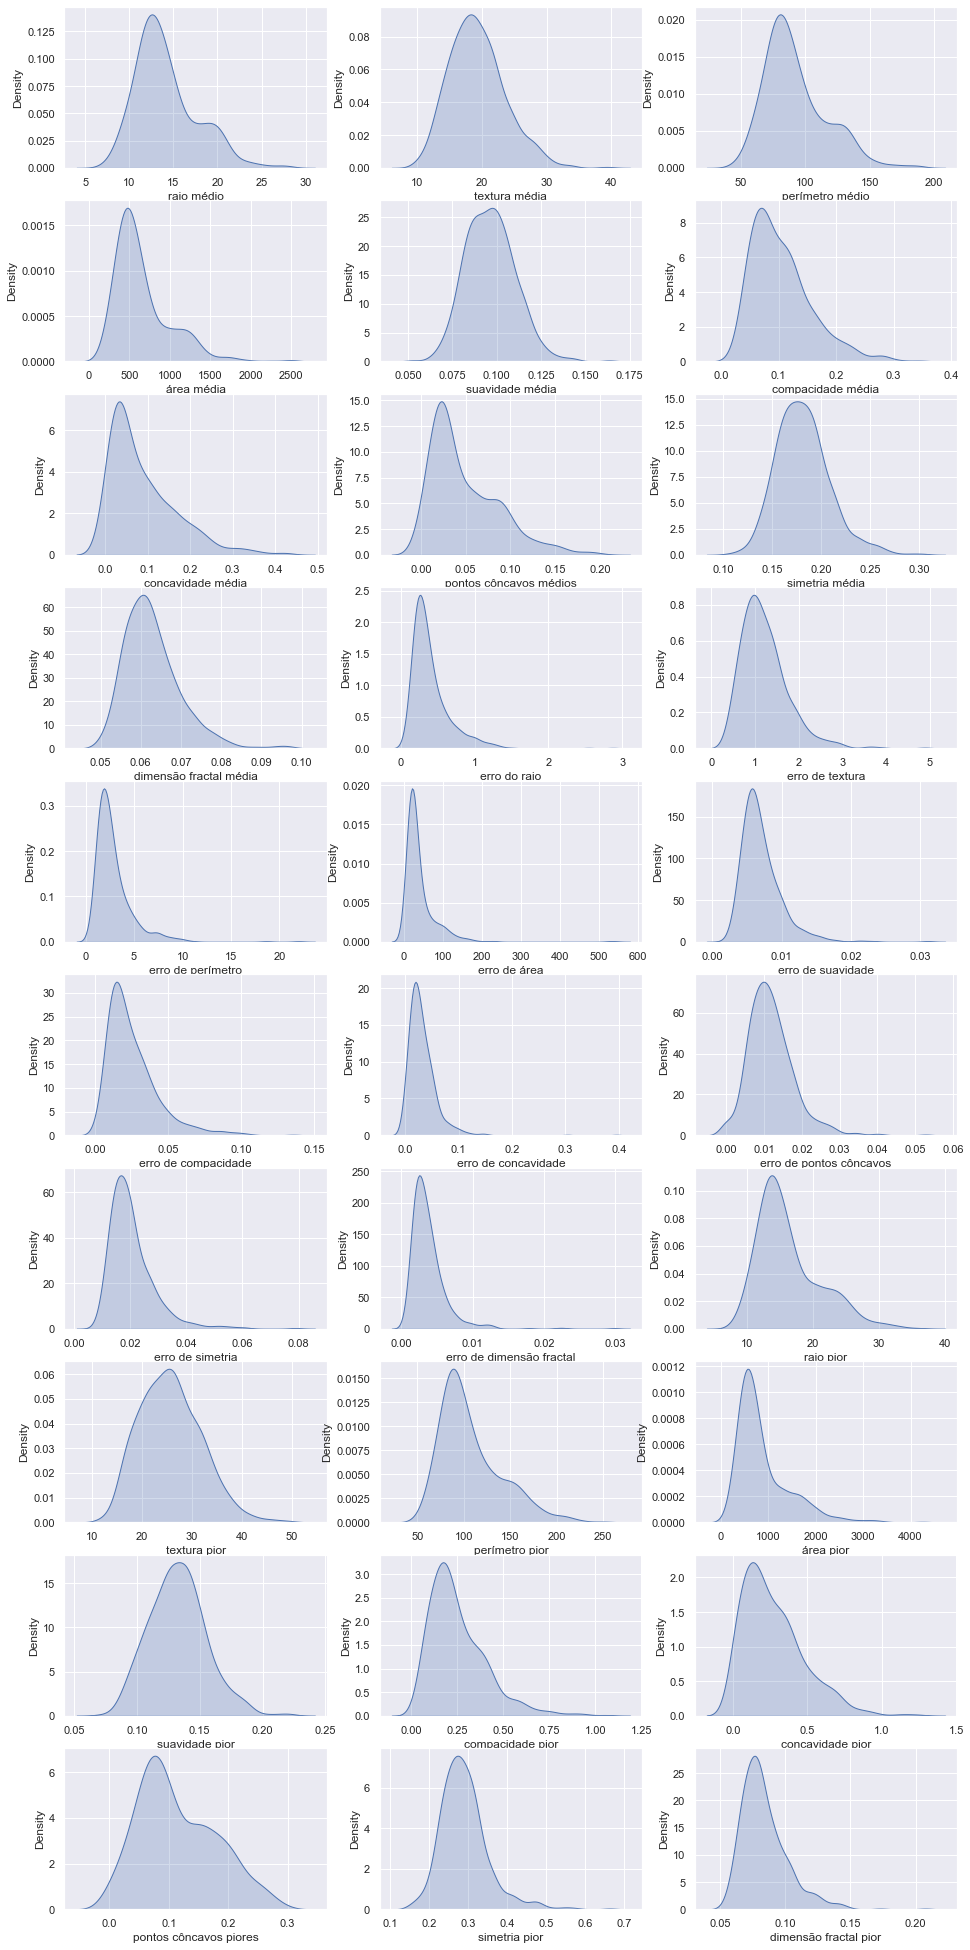

In [103]:
features_names = X.columns # nome das features

n_cols = int(min(len(features_names),3)) # número de colunas
n_rows = int(np.ceil(len(features_names)/n_cols)) # número de linhas

sns.set()
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16,35)) # criando a matriz para posição e tamanho dos gráficos
ax = ax.flatten() # transforma o ax em uma matriz unidimensional

for feature, ax in zip(features_names, ax):
    ax = sns.kdeplot(data=X, x=feature, ax=ax, fill=True) # plot da distribuição gaussiana da feature x na posição ax
    
plt.show()

De uma maneira geral, as distribuições das features possuem um comportamento gaussiano. Porém, algumas apresentam assimetrias e alguns formatos diferentes, mas não há distribuições bimodais. Além disso, as features possuem diferentes escalas. Dessa forma, seria de interesse padronizar os dados para deixar todos na mesma escala.

### Padronização dos dados

In [105]:
from sklearn.preprocessing import StandardScaler

zscore = StandardScaler()

X_padro = zscore.fit_transform(X) # retorna um array dos dados padronizados
X_padro = pd.DataFrame(X_padro, columns=X.columns) # transformando array em DataFrame


describe = X_padro.describe()
describe.loc[['std','mean'],:] # selecionando apenas o desvio e a média

raio médio  textura média  perímetro médio    área média  \
std   1.000880e+00   1.000880e+00     1.000880e+00  1.000880e+00   
mean -3.162867e-15  -6.530609e-15    -7.078891e-16 -8.799835e-16   

      suavidade média  compacidade média  concavidade média  \
std      1.000880e+00       1.000880e+00       1.000880e+00   
mean     6.132177e-15      -1.120369e-15      -4.421380e-16   

      pontos côncavos médios  simetria média  dimensão fractal média  ...  \
std             1.000880e+00    1.000880e+00            1.000880e+00  ...   
mean            9.732500e-16   -1.971670e-15           -1.453631e-15  ...   

         raio pior  textura pior  perímetro pior     área pior  \
std   1.000880e+00  1.000880e+00    1.000880e+00  1.000880e+00   
mean -2.333224e-15  1.763674e-15   -1.198026e-15  5.049661e-16   

      suavidade pior  compacidade pior  concavidade pior  \
std     1.000880e+00      1.000880e+00      1.000880e+00   
mean   -5.213170e-15     -2.174788e-15      6.856456e-16   

      pontos côncavos piores  simetria pior  dimensão fractal pior  
std             1.000880e+00   1.000880e+00           1.000880e+00  
mean           -1.412656e-16  -2.289567e-15           2.575171e-15  

[2 rows x 30 columns]

Com desvio padrão (std) próximo a 1 e média próxima a zero, a padronização foi feita com sucesso.

Como possui muitas features, para identificar as anomalias, será reduzida a dimensão do dataframe para duas dimensões.

### Redução de dimensionalidade com PCA

In [69]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_padro)
X_pca = pd.DataFrame(X_pca, columns=['x1','x2']) # transformando array em DataFrame

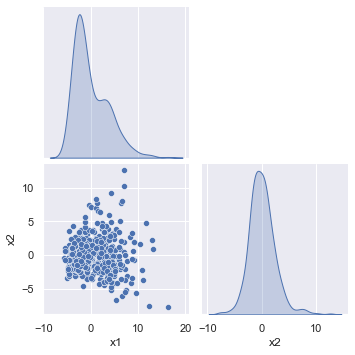

In [70]:
sns.pairplot(X_pca, corner=True, diag_kind='kde')

plt.show()

### Número ótimo de cluster com pontuação de silhueta

In [71]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

eps_values = [0.5, 1, 1.5]
min_samples_values = [3, 4, 5, 6, 7]

best_score = -1 # variável inicial para as iterações da pior pontuação de silhueta possível
best_eps = None
best_min_samples = None

# for dentro de for que vai testar todos as possibilidades de hiperparâmetros em dbscan
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples) # hiperparâmetros da iteração
        dbscan.fit(X_pca) # treino
        
        score = silhouette_score(X_pca, dbscan.labels_)
        
        if score > best_score:
            best_score = score
            best_eps = eps
            best_min_samples = min_samples

print(f'eps: {best_eps}\nmin_samples: {best_min_samples}')

eps: 1.5
min_samples: 7


### Treino e seleção de outliers

In [72]:
# Define o modelo DBSCAN
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels = dbscan.fit_predict(X_pca)

In [73]:
# função para plotar um scatterplot com as anomalias, cluster e regiões de clusters
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20,
                c='navy')
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=65)
    plt.scatter(non_cores[:, 0], non_cores[:, 1],
                c='k', marker=".", s=50)
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"eps={dbscan.eps:.2f}, min_samples={dbscan.min_samples}")
    plt.grid()
    plt.gca().set_axisbelow(True)

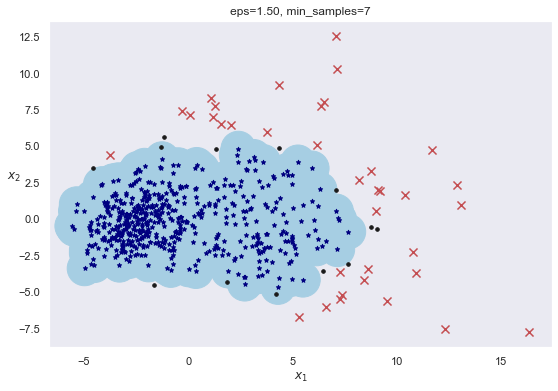

In [74]:
plt.figure(figsize=(9, 6))

plot_dbscan(dbscan, np.array(X_pca), size=1200)

plt.show()

In [75]:
y_anomalias = y[dbscan.labels_ == -1] # instâncias anomalias

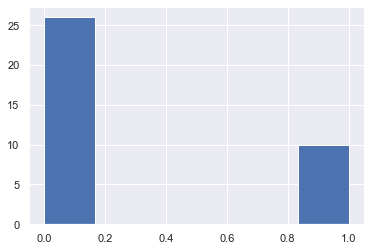

Percentual da malignos encontrados: 72.22%


In [76]:
plt.hist(y_anomalias, bins=6)

plt.show()

print(f'Percentual da malignos encontrados: {(len(y_anomalias[y_anomalias == 0]) / len(y_anomalias)):.2%}')

Pensando que não tivéssemos os dados rótulados, quando fossemos analisar as instâncias consideras de anomalias e compreende-las, observaríamos que a 73,68% das atribuídas como anomalias são consideradas.
- Dessa maneira, pode-ser realizar a analogia que instâncias mais distantes dos centros de densidade tem maior probabilidade de ser um tumor maligno e no caso de tumores, os falsos positivos não importão muito, mas falsos negativos sim.
- Como temos 569 instâncias é improvável que apenas aproximadamente 25 instâncias sejam tumores malignos, então a decisão mais interessante seria diminuir a distâncias episolon para afetar o critério de densidade. Levanto em conta a hipótese de que aqueles dados mais discreptantes dos centros de densidade são câncer malignos.

In [77]:
eps, min_samples

(1.5, 7)

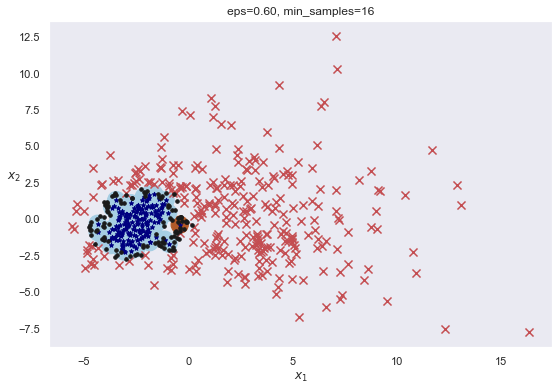

In [78]:
# Define o modelo DBSCAN
dbscan = DBSCAN(eps=0.60, min_samples=16)
labels = dbscan.fit_predict(X_pca)

plt.figure(figsize=(9, 6))

plot_dbscan(dbscan, np.array(X_pca), size=300)

plt.show()

In [79]:
y_anomalias = y[dbscan.labels_ == -1] # instâncias anomalias

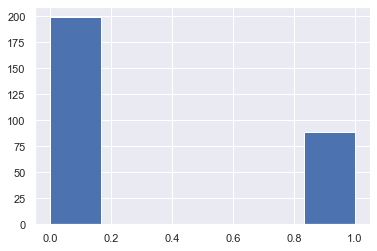

Percentual da malignos encontrados: 69.10%


In [80]:
plt.hist(y_anomalias, bins=6)

plt.show()

print(f'Percentual da malignos encontrados: {(len(y_anomalias[y_anomalias == 0]) / len(y_anomalias)):.2%}')

- No momento em que analisássemos novamente os dados considerados anomalias, obteríamos um valor de 69,10% das anomalias encontradas sendo tumores malignos e apesar de ser um percentual menor que antes, encontrou-se um valor muito maior de tumores comparado as anomalias encontradas com o treino do modelo anterior.

-----------

# Agrupamento Aglomerativo para segmentação de clientes com tratamento de outliers utilizando Mistura Gaussiana Bayesiana

O conjunto de dados Wholesale Customers tem oito recursos que representam o gasto anual de vários clientes em diferentes categorias de produtos e cada instância representa um cliente.

- O objetivo será entender as semelhanças e diferenças entre os clusters de clientes;

In [81]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
df = pd.read_csv(url)

renomear = {
    'Fresh': 'Carnes_Vegetais',
    'Milk': 'Leite',
    'Grocery': 'MerceariaGeral',
    'Frozen': 'Congelados',
    'Detergents_Paper': 'Detergentes_Papel',
    'Delicassen': 'Frios_Embutidos'
}

df.rename(columns=renomear, inplace=True)

display(df.head(), df.shape)

Channel  Region  Carnes_Vegetais  Leite  MerceariaGeral  Congelados  \
0        2       3            12669   9656            7561         214   
1        2       3             7057   9810            9568        1762   
2        2       3             6353   8808            7684        2405   
3        1       3            13265   1196            4221        6404   
4        2       3            22615   5410            7198        3915   

   Detergentes_Papel  Frios_Embutidos  
0               2674             1338  
1               3293             1776  
2               3516             7844  
3                507             1788  
4               1777             5185

(440, 8)

- A coluna "Channel" tem dois valores possíveis: 1 ou 2. O valor 1 representa a categoria de hotel/restaurante/café, enquanto o valor 2 representa a categoria de varejista.
- A coluna "Region" tem três valores possíveis: 1, 2 ou 3, que representam as três regiões geográficas em que os clientes estão localizados.

   - Ambastas features "Channel" e "Region" não terão relevância no agrupamento, de modo que o objetivo é entender semelhança dos gasotos do cliente no total.

In [82]:
df.drop(columns=['Region', 'Channel'], axis=1, inplace= True)

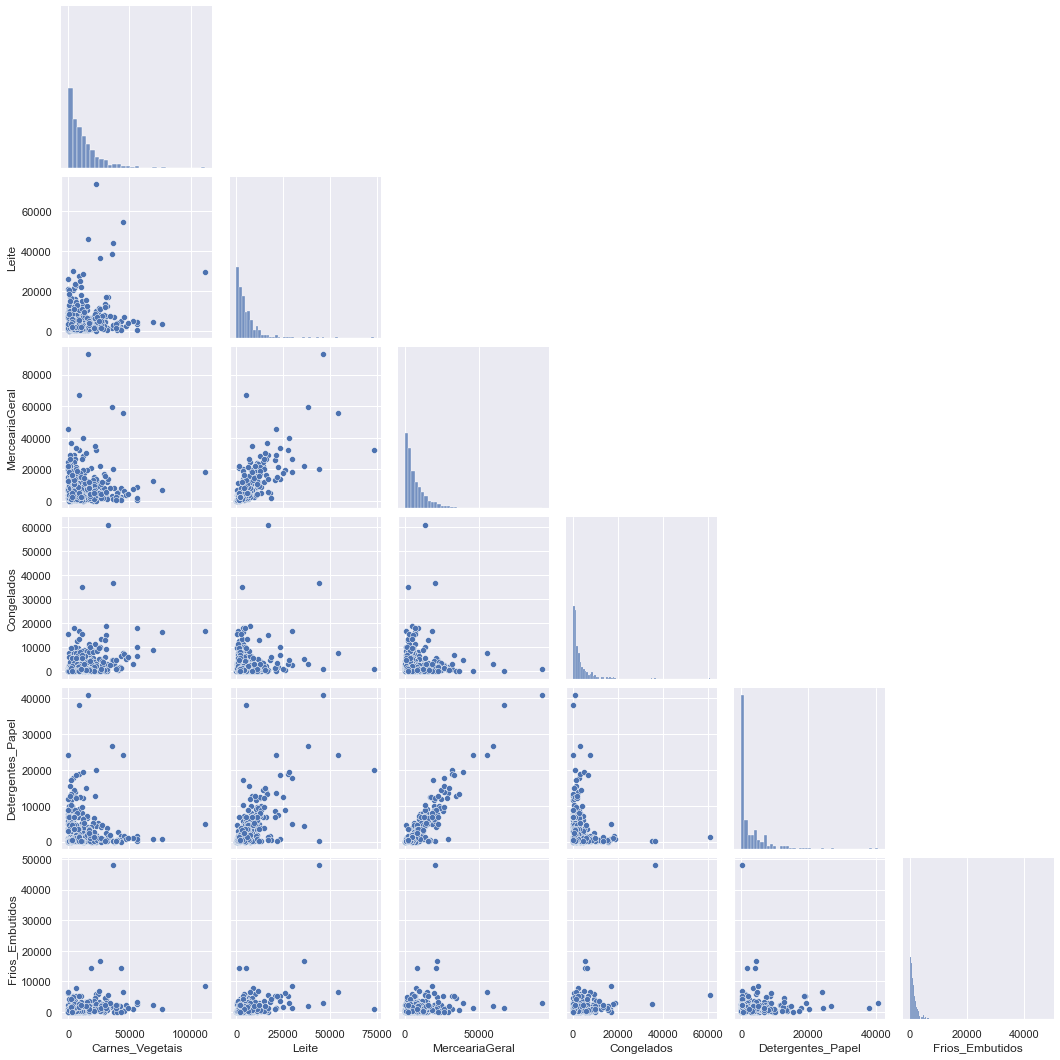

In [83]:
sns.pairplot(data=df, corner=True)

plt.show()

- Os dados se agrupam em difentes formatos e aparentemente não se adequaram ao formato circular de cluster;
- Há uma necessidade de padronizar os dados devido a diferença de escala;
- Percebe-se alguns outliers nos dados que não serão representativos para formar os clusters. Dessa forma, seria interessanse eliminálos.

In [111]:
# padronização através do z-score
zscore = StandardScaler()

array_padro = zscore.fit_transform(df) # dados padronizados

df_padro = pd.DataFrame(array_padro, columns=df.columns)

describe = df_padro.describe()
describe.loc[['std','mean'],:] # selecionando apenas o desvio e a média

Carnes_Vegetais         Leite  MerceariaGeral    Congelados  \
std      1.001138e+00  1.001138e+00    1.001138e+00  1.001138e+00   
mean    -2.422305e-17 -1.589638e-17   -6.030530e-17  1.135455e-17   

      Detergentes_Papel  Frios_Embutidos  
std        1.001138e+00     1.001138e+00  
mean      -1.917658e-17    -8.276208e-17

- Padronização realizada com sucesso.

In [112]:
# pca para
pca = PCA(n_components=2)

array_pca = pca.fit_transform(df_padro)

df_pca = pd.DataFrame(array_pca, columns=['x1','x2'])

In [113]:
# tratamento de outliers com Mistura Gaussiana Bayesiana
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

bgm.fit(df_pca)

bgm.weights_.round(2) # k = 6 segundo bgm

array([0.18, 0.05, 0.05, 0.02, 0.01, 0.26, 0.42, 0.  , 0.  , 0.  ])

In [116]:
log_prob = bgm.score_samples(df_pca) # retorna o logaritmo da função de probabilidade densidade

prob_threshold  = np.percentile(log_prob, 3) # o valor limite de densidade abaixo do qual 5% dos
                                                 # dados serão outliers
    
print(f'Logaritmo da Probabilidade Densidade:\n{log_prob[:10]}\n\n\
Valor limite de Probabilidade Densidade: {prob_threshold}')

Logaritmo da Probabilidade Densidade:
[-2.28838549 -2.39376758 -4.60511115 -1.67971922 -3.43355917 -2.27200409
 -2.23701684 -2.36357311 -2.20040236 -2.93127291]

Valor limite de Probabilidade Densidade: -6.674376235757727


- Valores abaixo de -12,16 de probabilidade densidade serão cosniderados outliers.

In [ ]:
# detectando outliers
outliers = df_pca[log_prob < prob_threshold]

# filtrando outliers
df_clean = df_pca[log_prob > prob_threshold]

In [89]:
display(df_clean.shape, outliers.shape)

(418, 2)

(22, 2)

C:\Users\Client\AppData\Local\Temp\ipykernel_8148\54569635.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


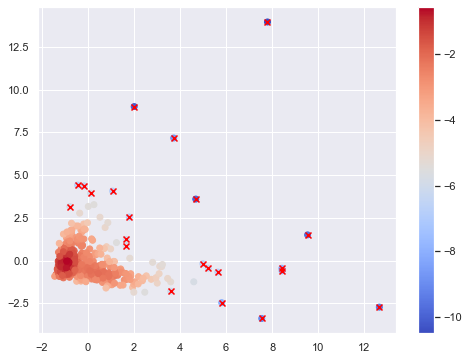

In [90]:
plt.figure(figsize=(8,6))

plt.scatter(df_pca['x1'], df_pca['x2'], c=log_prob, cmap='coolwarm')
plt.grid(True)
plt.colorbar()
plt.scatter(outliers['x1'], outliers['x2'], color='red', marker='x')

plt.show()

Com os outliers eliminados dos dados, pode-se realizar o Clustering Hierárquico Aglomerativo

In [91]:
# escolha dos
from sklearn.cluster import AgglomerativeClustering

linkages = ['complete', 'average', 'single', 'ward']
n_clusters = [2, 3, 4, 5, 6, 7, 8]

best_score = -1 # variável inicial para as iterações da pior pontuação de silhueta possível
best_linkage = None
best_n_cluster = None

# for dentro de for que vai testar todos as possibilidades de hiperparâmetros em dbscan
for linkage in linkages:
    for n_cluster in n_clusters:
        aggc = AgglomerativeClustering(n_clusters=n_cluster, linkage=linkage)
        aggc.fit(df_clean)
        
        score = silhouette_score(df_clean, aggc.labels_)
        
        if score > best_score:
            best_score = score
            best_linkage = linkage
            best_n_cluster = n_cluster

print(f'n_cluster: {best_n_cluster}\nlinkage: {best_linkage}')

n_cluster: 2
linkage: single


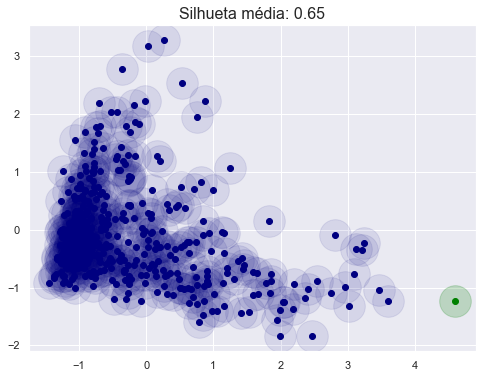

In [92]:
aggc = AgglomerativeClustering(n_clusters=best_n_cluster, linkage=best_linkage) # modelo com os melhores hiperparâmetros
aggc.fit(df_clean)

label_aggc = aggc.labels_ # rótulo para cada instâncias

score = silhouette_score(df_clean, aggc.labels_) # pontuação de silhueta

plt.figure(figsize=(8,6))

plt.scatter(df_clean['x1'][label_aggc==0], df_clean['x2'][label_aggc==0], color='navy', s=1000, alpha=0.085)
plt.scatter(df_clean['x1'][label_aggc==1], df_clean['x2'][label_aggc==1], color='green', s=1000, alpha=0.2)

plt.scatter(df_clean['x1'][label_aggc==0], df_clean['x2'][label_aggc==0], color='navy')
plt.scatter(df_clean['x1'][label_aggc==1], df_clean['x2'][label_aggc==1], color='green')

plt.title(f'Silhueta média: {score:.2f}', fontsize=16)
plt.grid(True)

plt.show()

Algoritmo com maior pontuação de silhueta não conseguiu segmentar os clientes em clusters de maneira eficiente. Possivelmente por utilizar a linkage 'single' o algoritmo convergiu para um modelo muito simples.
- Uma solução é testar o algoritmo com outros tipos de linkage e número de clusters enquanto avalia a pontuação de silhueta;

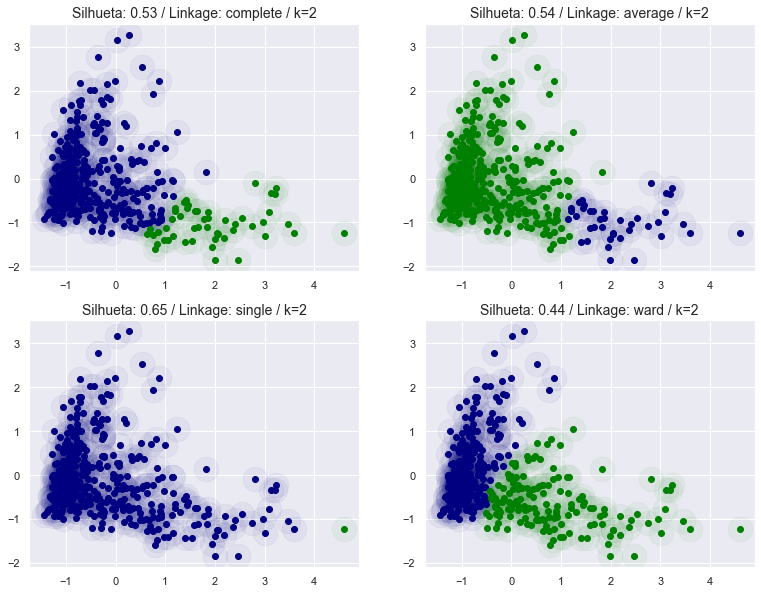

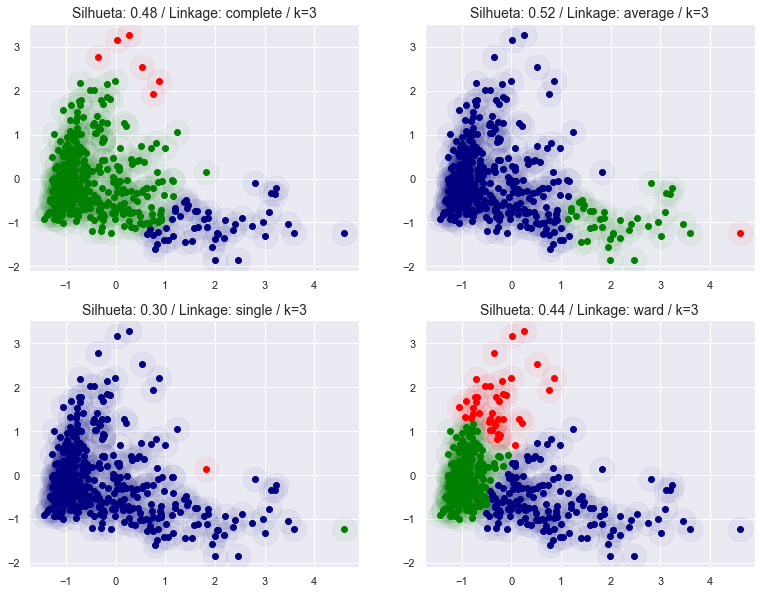

In [93]:
linkages = ['complete', 'average', 'single', 'ward'] # nome das features

n_cols = int(min(len(linkages),2)) # número de colunas
n_rows = int(np.ceil(len(linkages)/n_cols)) # número de linhas

sns.set()
fig, ax = plt.subplots(n_rows, n_cols, figsize=(13,10)) # criando a matriz para posição e tamanho dos gráficos
ax = ax.flatten() # transforma o ax em uma matriz unidimensional

for linkage, ax in zip(linkages, ax):
    aggc = AgglomerativeClustering(n_clusters=2, linkage=linkage) # modelo com os melhores hiperparâmetros
    aggc.fit(df_clean)

    label_aggc = aggc.labels_ # rótulo para cada instâncias

    score = silhouette_score(df_clean, aggc.labels_) # pontuação de silhueta
    
    ax.scatter(df_clean['x1'][label_aggc==0], df_clean['x2'][label_aggc==0], color='navy', s=600, alpha=0.045)
    ax.scatter(df_clean['x1'][label_aggc==1], df_clean['x2'][label_aggc==1], color='green', s=600, alpha=0.045)

    ax.scatter(df_clean['x1'][label_aggc==0], df_clean['x2'][label_aggc==0], color='navy')
    ax.scatter(df_clean['x1'][label_aggc==1], df_clean['x2'][label_aggc==1], color='green')

    ax.set_title(f'Silhueta: {score:.2f} / Linkage: {linkage} / k=2', fontsize=14)
    ax.grid(True)
    
plt.show()

linkages = ['complete', 'average', 'single', 'ward'] # nome das features

n_cols = int(min(len(linkages),2)) # número de colunas
n_rows = int(np.ceil(len(linkages)/n_cols)) # número de linhas

sns.set()
fig, ax = plt.subplots(n_rows, n_cols, figsize=(13,10)) # criando a matriz para posição e tamanho dos gráficos
ax = ax.flatten() # transforma o ax em uma matriz unidimensional

for linkage, ax in zip(linkages, ax):
    aggc = AgglomerativeClustering(n_clusters=3, linkage=linkage) # modelo com os melhores hiperparâmetros
    aggc.fit(df_clean)

    label_aggc = aggc.labels_ # rótulo para cada instâncias

    score = silhouette_score(df_clean, aggc.labels_) # pontuação de silhueta
    
    ax.scatter(df_clean['x1'][label_aggc==0], df_clean['x2'][label_aggc==0], color='navy', s=600, alpha=0.045)
    ax.scatter(df_clean['x1'][label_aggc==1], df_clean['x2'][label_aggc==1], color='green', s=600, alpha=0.045)
    ax.scatter(df_clean['x1'][label_aggc==2], df_clean['x2'][label_aggc==2], color='red', s=600, alpha=0.045)

    ax.scatter(df_clean['x1'][label_aggc==0], df_clean['x2'][label_aggc==0], color='navy')
    ax.scatter(df_clean['x1'][label_aggc==1], df_clean['x2'][label_aggc==1], color='green')
    ax.scatter(df_clean['x1'][label_aggc==2], df_clean['x2'][label_aggc==2], color='red')

    ax.set_title(f'Silhueta: {score:.2f} / Linkage: {linkage} / k=3', fontsize=14)
    ax.grid(True)
    
plt.show()

Qualitativamente, em uma análise visual ***n_clusters = 3, linkage='ward'*** e ***n_clusters = 2, linkage='ward'*** pois aparentemente equilibram melhor os pesos dos clusters e conseguem separar clusters com variância similar. 

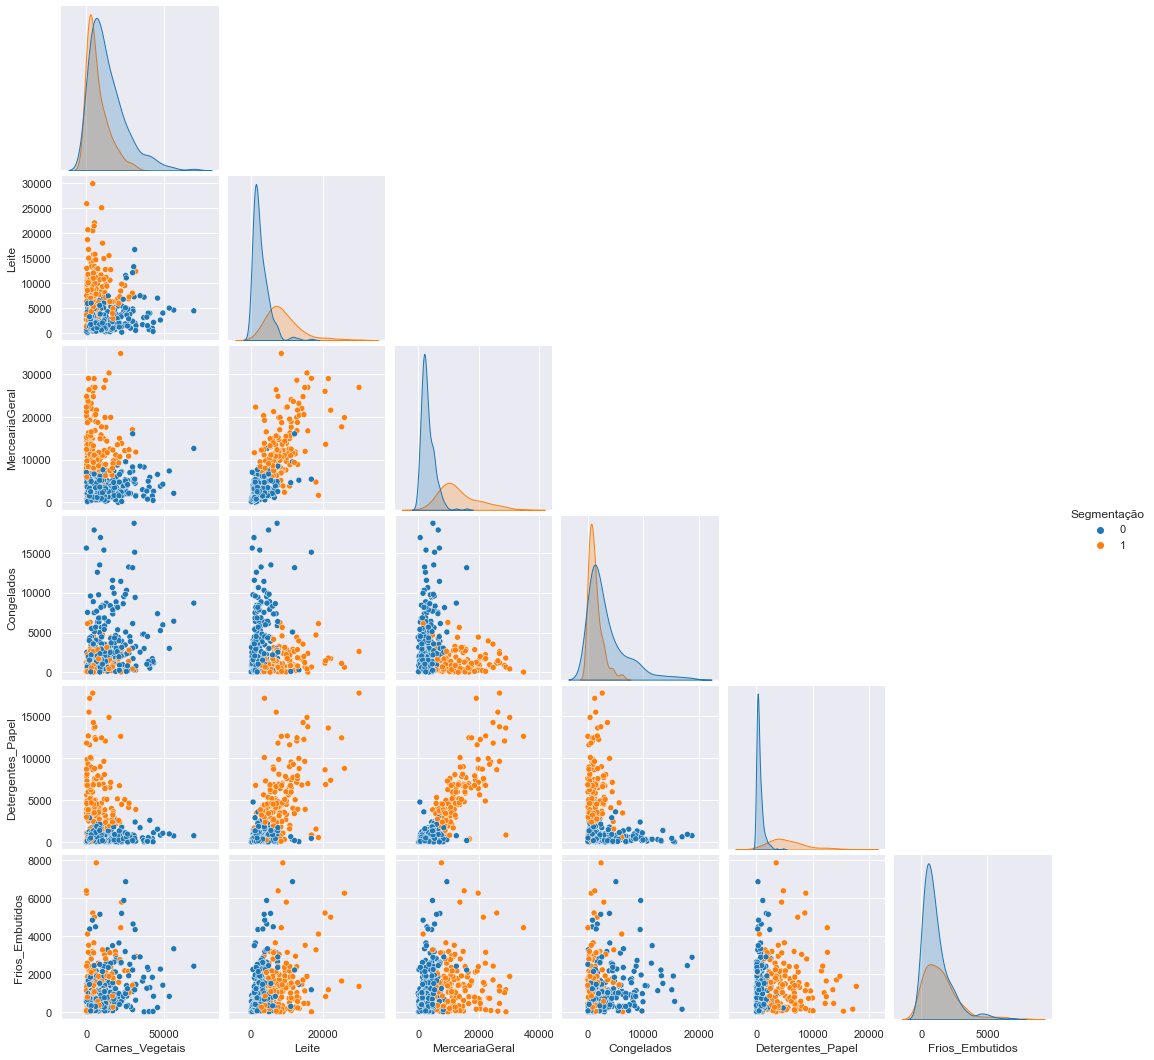

In [94]:
# n_clusters = 2, likage='ward'
aggc_k2 = AgglomerativeClustering(n_clusters = 2, linkage='ward')
aggc_k2.fit(df_clean)

label_aggc_k2 = aggc_k2.labels_ # rótulos

df_k2 = df[log_prob > prob_threshold].copy() # limpando outliers dos dados sem padronização e PCA

df_k2['Segmentação'] = label_aggc_k2 # criando feature com os rótulos atribuindo a que cluster cada cliente pertence

sns.pairplot(data=df_k2, corner=True, hue='Segmentação', palette='tab10')
plt.show()

In [95]:
# groupby em relação aos clusters da feature Segmentação com a média das features
print(f'n instância 0: {len(df_k2[df_k2.Segmentação == 0])}\nn instância 1: {len(df_k2[df_k2.Segmentação == 1])}')
df_k2.groupby('Segmentação').mean().head()

n instância 0: 266
n instância 1: 152


Carnes_Vegetais        Leite  MerceariaGeral   Congelados  \
Segmentação                                                              
0               13464.236842  2609.800752     3103.533835  3382.026316   
1                6937.717105  8771.552632    13334.473684  1312.947368   

             Detergentes_Papel  Frios_Embutidos  
Segmentação                                      
0                   551.654135      1106.823308  
1                  5635.500000      1464.026316

Na segmentação em dois grandes grupos pode-se perceber tanto no gráfico *pairplot* quanto nas médias das features para os clusters de segmentação que eles possuem algumas grandes diferenças entre si que poderão ser utilizadas num *sistema de recomendação*. Por exemplo

- Clientes do cluster 0 tendem a:
   - Gastar com carnes, vagerais e congelados;
   - Não possuem tendência a gastar com detergentes e papel;
   
   
- Clientes do cluster 1 tendem a:
   - Gastar com leite, mercearia geral (não perecíveis, produtos de beleza, etc), detergentes e papel;
   - Não possuem tendência a gastar com congelados;
  
 
 - Ambos não possuem muita afinidade com frios e embutidos;

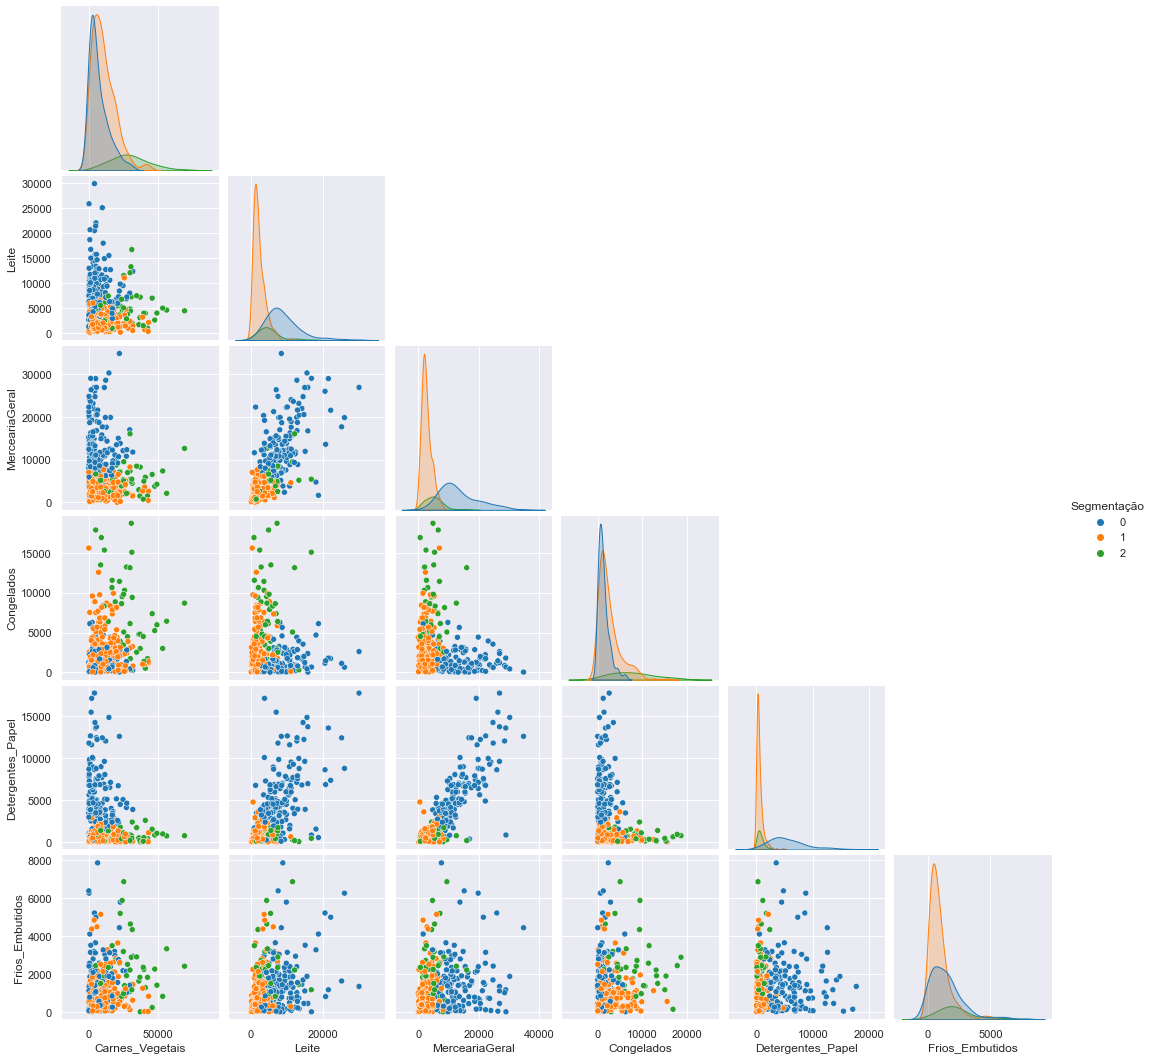

In [96]:
# n_clusters = 3, likage='ward'
aggc_k3 = AgglomerativeClustering(n_clusters = 3, linkage='ward')
aggc_k3.fit(df_clean)

label_aggc_k3 = aggc_k3.labels_ # rótulos

df_k3 = df[log_prob > prob_threshold].copy() # limpando outliers dos dados sem padronização e PCA

df_k3['Segmentação'] = label_aggc_k3 # criando feature com os rótulos atribuindo a que cluster cada cliente pertence

sns.pairplot(data=df_k3, corner=True, hue='Segmentação', palette='tab10')
plt.show()

In [97]:
# groupby em relação aos clusters da feature Segmentação com a média das features
print(f'n instância 0: {len(df_k3[df_k3.Segmentação == 0])}\nn instância 1: {len(df_k3[df_k3.Segmentação == 1])}\n\
n instância 2: {len(df_k3[df_k3.Segmentação == 2])}')
df_k3.groupby('Segmentação').mean().head()

n instância 0: 152
n instância 1: 224
n instância 2: 42


Carnes_Vegetais        Leite  MerceariaGeral   Congelados  \
Segmentação                                                              
0                6937.717105  8771.552632    13334.473684  1312.947368   
1               10469.973214  2157.571429     2707.500000  2544.468750   
2               29433.642857  5021.690476     5215.714286  7849.000000   

             Detergentes_Papel  Frios_Embutidos  
Segmentação                                      
0                  5635.500000      1464.026316  
1                   517.758929       895.611607  
2                   732.428571      2233.285714

- Clientes do cluster 0 tendem a:
   - Gastar com mercearia geral, leite, detergente e papel;
   - O que menos compram são congelados;
   
   
- Clientes do cluster 1 tendem a:
   - Gastar com carnes e vegetais, mas menos do que o cluster 2;
   - De uma maneira geral gastam menos que os demais e não tendem a gastar com detergentes, papel, frios e embutidos;
   
   
- Clientes do cluster 2 tendem a:
   - Gastar muito com carnes e vegetais, congelados e são que mais compram embutidos (apesar de não ser muito impactante perante aos outros gastos);
   - Tendem a não gastar com detergentes e papel;
   - Possui menos clientes, portanto é menos representativa